# 4.1 二分类问题 imdb 电影评论分类

这里使用的是 imdb 电影评论.将评论分为推荐或者不推荐.


## 4.1.1 imdb 数据集

imdb 数据集

- 50000 条评论,25000 用于训练,25000 用于验证.
- 为了方便训练,每一个整数代表一个档次,评论被转换成了整数序列.

In [1]:
from keras.datasets import imdb
(train_data, train_labels), (test_data,
                             test_labels) = imdb.load_data(num_words=10000)

加载 imdb 数据集时,参数 num_words 意味着只取词频前 10000 的单词.其他低频词被忽略.

imdb 数据集原本有 88585 个不同单词,许多词只出现一次,限制单词数量可以降低计算复杂度.


In [2]:
print(train_data[0])
print(train_labels[0])


[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


train_data test_data 是单词索引组成的列表的列表. train_labels 和 test_labels 代表评论的正面(1)负面(0)


In [20]:
max([max(sequence) for sequence in train_data])

9999

限制了单词字典的总数量,索引索引最大 9999


In [3]:
word_index = imdb.get_word_index()  #将单词映射成整数的字典
reverse_word_index = dict([(value, key) \
        for (key, value) in word_index.items()])  #颠倒 value key
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])# 解码组合单词

print(decoded_review)
print(len(word_index))
print(len(reverse_word_index))


? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

这是将评论由整数数组还原成字符串的过程.

decoded_review 时,因为在数据集中 0 1 2 是为了 padding, start of sequence 和 unknow 保留的索引,所以数据集中的单词索引会比映射字典的索引大 3.


## 4.1.2 准备数据

电影评论有长有短,而且神经网络也无法直接处理整数序列.开始训练之前我们要将数据转换成神经网络能接受的输入.

- 既然评论有长有短,干脆都填充到最大长度.之后将列表转换成 (samples, max_length) 形状的整数张量.keras 有专门处理整数张量的层(Embedding 之后会提及)
- 或者换一种,不填充列表,反正单词限定只有 10000 个,使用一个 1d 1000 维的张量,就能表示全部的整数序列.例如整数序列 `[3,5]` 只在 3,5 取 1,其他位置取 0.在书中叫对列表进行 one-hot 编码.


In [4]:
import numpy as np


def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences),dimension))  # 初始化全 0 2d 张量
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1  #sequences 第 i 个整数序列包含的整数值在 results 中的位置设为 1
    return results


x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)


In [5]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

上面是手动实现的 one-hot 编码.


In [6]:
y_train = np.asarray(train_labels).astype("float32")  # 标签是直接 np 新建张量
y_test = np.asarray(test_labels).astype("float32")

评论和标签都准备完毕.


## 4.1.3 构建模型

输入数据是向量,输出数据是标量.这几乎是深度学习遇到的最简单的问题了.使用 rule 激活函数的 dense layer 的堆叠可以很好的解决这个问题.

dense 层堆叠的模型有两个关键参数

- 模型有几个 dense layer
- 每层各有多少隐藏单元.

第五章会有指导如何选择合适的参数,但是这里暂时直接给出:

- 3 层网络,2 个中间层.第 3 层输出结果.
- 2 个中间层各有 16 个隐藏单元.

![3_layer_network](./3_layer_network.png)


In [7]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),  #16隐藏单元
    layers.Dense(16, activation="relu"),  #16隐藏单元
    layers.Dense(1, activation="sigmoid")
])

2022-04-27 02:34:54.089560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-27 02:34:54.121168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-27 02:34:54.121451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-27 02:34:54.122193: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

前面 2 章的内容,layers.Dense(16, activation="relu") 实际上是做了 `output = relu(dot(input, W) + b)`.

- 与 W 点积是将输入向量投射到 16 维空间,+b 进行偏置,最后进入激活函数,这里是 relu.
- 隐藏单元越多,从数据可能学习到的规律越多,但是计算的代价越大.学习能力过强,可能会挖掘训练集过多特征,但是这些特征在验证集上并没有作用.


激活函数,上面的模型使用了 2 个激活函数,中间层是 relu 输出层是 sigmoid.

- relu(整流线性单元) 旨在将负值归零.![relu](./The-rectified-linear-unit-function.png)
- sigmoid 旨在将任意值压缩到 `[0,1]` 区间.![sigmoid](./The-sigmoid-function.png)


为什么激活函数是必须的?

dense 层只有两个线性运算.+ 和 点积.dense layer 也只能搜索可能的线性组合.这样的假设空间非常受限,即使叠加多层,多层直接依然是线性运算的叠加,假设空间依旧是线性变换的空间.

添加非线性的激活函数,这样多层之间不再是线性运算的叠加,可以大大拓展假设空间.常用的激活函数是 relu 但是还有其他的激活函数可选.上面的 sigmoid elu prelu 等等.


In [8]:
model.compile(
    optimizer='rmsprop',  #优化器
    loss='binary_crossentropy',  #损失函数
    metrics=['accuracy'])  #指标


选定模型的损失函数和优化器.

- 二分类问题,模型输出的是概率.最好的优化器是 binary_crossentropy (二元交叉熵),当然它不是唯一的选择,mean_squared_error(均方误差)也可,但是 binary_crossentropy 对于输出概率的模型往往是更好的选择.
- 优化器则是 rmsprop ,通常适用于大部分问题.
- 指标选择了 accuracy,准确率.


## 4.1.4 验证你的模型

深度学习模型永远不应该在其训练数据上评估,通行的做法是训练数据专门切割出一部分做验证集,用来评估训练期间模型的表现.

In [9]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

分出 10000 来作为验证集.传入 `validation_data`


In [10]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))


Epoch 1/20
30/30 [==============================] - 3s 35ms/step - loss: 0.5049 - accuracy: 0.7904 - val_loss: 0.3822 - val_accuracy: 0.8666
Epoch 2/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2974 - accuracy: 0.9057 - val_loss: 0.3028 - val_accuracy: 0.8884
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.2192 - accuracy: 0.9283 - val_loss: 0.3007 - val_accuracy: 0.8803
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1738 - accuracy: 0.9439 - val_loss: 0.2775 - val_accuracy: 0.8877
Epoch 5/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1420 - accuracy: 0.9539 - val_loss: 0.3274 - val_accuracy: 0.8720
Epoch 6/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1203 - accuracy: 0.9625 - val_loss: 0.2939 - val_accuracy: 0.8848
Epoch 7/20
30/30 [==============================] - 0s 17ms/step - loss: 0.0983 - accuracy: 0.9709 - val_loss: 0.3194 - val_accuracy: 0.8832
Epoch 8/20
30

这里选择训练 20 轮,每个轮次 batch_size 512..妥妥的过拟合.


In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

history 包含一个成员 history,其中包括了训练和验证期间的每一个指标变化,在训练集+验证集.

在训练集的准确度和损失,在验证集的准确度和损失.

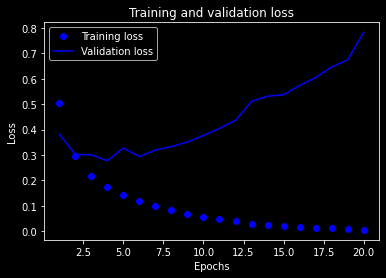

In [12]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

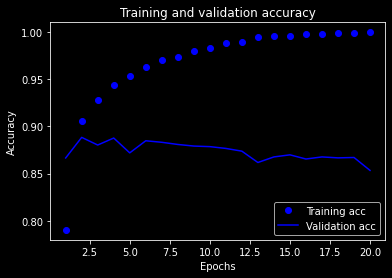

In [13]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

从结果来看,似乎到第 4 轮训练时,模型在验证集上结果做好.过多的轮次带来了越来越严重的过拟合.

第五章会介绍如何减轻过拟合.现在从头训练一个 4 轮次模型.


In [14]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 10ms/step - loss: 0.4395 - accuracy: 0.8239
Epoch 2/4
49/49 [==============================] - 1s 11ms/step - loss: 0.2531 - accuracy: 0.9108
Epoch 3/4
49/49 [==============================] - 1s 11ms/step - loss: 0.1978 - accuracy: 0.9276
Epoch 4/4
782/782 [==============================] - 4s 5ms/step - loss: 0.3001 - accuracy: 0.8818


In [15]:
results

[0.3000788986682892, 0.8817600011825562]

所以训练 4 轮的模型在验证集的的准确度在 87% 88%,如果使用最先进的方法应该会在 95%.


### 4.1.6 使用模型预测数据

In [16]:
model.predict(x_test)

array([[0.25173965],
       [0.9998136 ],
       [0.9774818 ],
       ...,
       [0.13977584],
       [0.08562437],
       [0.6313101 ]], dtype=float32)

model.predict 验证结果,验证集的准确度 87%,所以最终测试上模型 0.7 这样的不是那么确定到底是哪一类的评论.


## 附加内容,一些改变模型参数的尝试

In [27]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),# 基准
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=8, batch_size=512,validation_data=(x_test, y_test))

Epoch 1/8
49/49 [==============================] - 3s 48ms/step - loss: 0.4690 - accuracy: 0.8184 - val_loss: 0.3612 - val_accuracy: 0.8657
Epoch 2/8
49/49 [==============================] - 1s 20ms/step - loss: 0.2677 - accuracy: 0.9092 - val_loss: 0.2891 - val_accuracy: 0.8889
Epoch 3/8
49/49 [==============================] - 1s 19ms/step - loss: 0.2047 - accuracy: 0.9286 - val_loss: 0.2996 - val_accuracy: 0.8804
Epoch 4/8
49/49 [==============================] - 1s 18ms/step - loss: 0.1703 - accuracy: 0.9418 - val_loss: 0.2952 - val_accuracy: 0.8844
Epoch 5/8
49/49 [==============================] - 1s 19ms/step - loss: 0.1456 - accuracy: 0.9510 - val_loss: 0.3142 - val_accuracy: 0.8794
Epoch 6/8
49/49 [==============================] - 1s 19ms/step - loss: 0.1250 - accuracy: 0.9587 - val_loss: 0.3380 - val_accuracy: 0.8742
Epoch 7/8
49/49 [==============================] - 1s 18ms/step - loss: 0.1070 - accuracy: 0.9652 - val_loss: 0.3640 - val_accuracy: 0.8696
Epoch 8/8
49/49 [===

到第 3 轮,最好结果是 0.8882 之后过拟合了.

In [28]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),# 增加一个隐藏层
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=8, batch_size=512,validation_data=(x_test, y_test))

Epoch 1/8
49/49 [==============================] - 3s 43ms/step - loss: 0.4970 - accuracy: 0.7966 - val_loss: 0.3565 - val_accuracy: 0.8834
Epoch 2/8
49/49 [==============================] - 1s 25ms/step - loss: 0.2754 - accuracy: 0.9068 - val_loss: 0.2991 - val_accuracy: 0.8840
Epoch 3/8
49/49 [==============================] - 1s 29ms/step - loss: 0.2131 - accuracy: 0.9260 - val_loss: 0.2970 - val_accuracy: 0.8828
Epoch 4/8
49/49 [==============================] - 1s 28ms/step - loss: 0.1730 - accuracy: 0.9408 - val_loss: 0.3059 - val_accuracy: 0.8788
Epoch 5/8
49/49 [==============================] - 1s 26ms/step - loss: 0.1495 - accuracy: 0.9484 - val_loss: 0.3191 - val_accuracy: 0.8787
Epoch 6/8
49/49 [==============================] - 1s 27ms/step - loss: 0.1299 - accuracy: 0.9552 - val_loss: 0.3405 - val_accuracy: 0.8752
Epoch 7/8
49/49 [==============================] - 1s 24ms/step - loss: 0.1144 - accuracy: 0.9611 - val_loss: 0.3696 - val_accuracy: 0.8716
Epoch 8/8
49/49 [===

第 3 轮 0.8885 之后过拟合了,貌似第二轮就已经快到临界了.

In [ ]:
model = keras.Sequential([
    layers.Dense(32, activation="relu"),# 增加隐藏层单元
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=8, batch_size=512,validation_data=(x_test, y_test))

验证集结果来回波动,第一次基本就到头了 0.8848. 是隐藏单元增加假设空间,然后训练的轮次也跟着变少了?

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),# 增加隐藏层单元
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=8, batch_size=512,validation_data=(x_test, y_test))

基本类似上面情况.

In [ ]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),# 一个隐藏层
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=8, batch_size=512,validation_data=(x_test, y_test))

单隐藏层,过拟合后似乎不会衰减那么快.

In [ ]:
model = keras.Sequential([
    layers.Dense(32, activation="relu"),# 一个隐藏层
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=8, batch_size=512,validation_data=(x_test, y_test))

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),# 一个隐藏层
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=8, batch_size=512,validation_data=(x_test, y_test))

最终无论如何来回换,测试集的准确度最高都是 88% 偶尔 有 89%,应该是这个问题, dense 堆叠的极限了.


## 结论

带有 relu 激活的 Dense 层堆叠,可以适用于很多问题,但是极限效果还需要换用其他网络架构.

二分类问题的最后一层是使用 sigmoid 激活的 Dense 层,网络输出应该是0~1范围内的标量，表示概率值.

二分类问题的sigmoid标量输出,你应该使用binary_crossentropy损失函数.
